In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from torchvision import transforms
import zookeeper as zk
import os
from tqdm import tqdm
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('spada e s' + str(device))

mappy = True  ### if the Net isn't originally mapped -> False
rgb = False

transform = transforms.Compose([
    transforms.ToTensor(), # Riscala le immagini tra 0 e 1
    transforms.CenterCrop(324),
    transforms.Resize(128),
])

spada e scuda


In [3]:
class GalaxyJungle(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, mappy=False, is_rgb=False):
        self.rgb = is_rgb
        self.mappy = mappy
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        
    
    def __len__(self): return (self.img_labels).shape[0]

    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, str(self.img_labels.iloc[idx, 0])) + '.jpg'
        image = Image.open(img_path)
        if not self.rgb: image = image.convert('L')
        if self.transform: image = self.transform(image)
        
        label = self.img_labels.iloc[idx, 1:]        
        label = torch.tensor(label.values, dtype=torch.float32)
        if self.mappy: label = zk.mappy(label)

        gal_id = self.img_labels.iloc[idx, 0]

        return image, label, gal_id

In [4]:
class GalaxyNet(nn.Module):
    def __init__(self, activation, initialization=False, mappy=False, is_rgb=False):
        super().__init__()
        
        self.mappy = mappy
        rgb = 3 if is_rgb else 1
        input_size = 128
        num_labels = 37
        self.loss_dict = {'batch' : [], 'epoch' : [], 'vbatch' : [], 'vepoch' : []}
        self.activation = activation
        
        self.convs = nn.Sequential(
            nn.Conv2d(rgb, 16, 3, padding='same', bias=False),
            self.activation(),
            nn.BatchNorm2d(16),

            nn.Conv2d(16, 16, 3, padding='same', bias=False),
            self.activation(),
            nn.BatchNorm2d(16),
            
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, 3, padding='same', bias=False),
            self.activation(),
            nn.BatchNorm2d(32),
            
            nn.Conv2d(32, 32, 3, padding='same', bias=False),
            self.activation(),
            nn.BatchNorm2d(32),

            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, bias=False),
            self.activation(),
            nn.BatchNorm2d(64),

            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, bias=False),
            self.activation(),
            nn.BatchNorm2d(128),

            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, 3, bias=False),
            self.activation(),
            nn.BatchNorm2d(256),

            nn.MaxPool2d(2)
            )

        for layer in self.convs:
            if layer.__class__.__name__ == 'Conv2d': input_size = zk.convool_size(input_size, 3, 1, 'same' if layer.padding == 'same' else 0)
            elif layer.__class__.__name__ == 'MaxPool2d': input_size = zk.convool_size(input_size, 2, 2)

        if input_size < 2: raise ValueError('You shrank too much dude.')
        print(f'Convs output size: {input_size}')

        input_linear = 256 * input_size * input_size
        
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_linear, 100),
            self.activation(),
            nn.Linear(100, num_labels)
            )
        
        if initialization: self.init_weights()



    def forward(self, x):
        x = self.convs(x)
        x = self.fc(x)
        if self.mappy: x = zk.mappy2D(x)
        return x


    def init_weights(self):
        if self.activation == nn.ReLU:
            nonlin = 'relu'
            a = 0
        elif self.activation == nn.LeakyReLU:
            nonlin = 'leaky_relu'
            a = .01
        
        for layer in self.convs: 
            if layer.__class__.__name__ == 'Conv2d': nn.init.kaiming_normal_(layer.weight, a=a, nonlinearity=nonlin)        

        for i in (1, -1): nn.init.constant_(self.fc[i].bias, 0)
 
        nn.init.kaiming_normal_(self.fc[1].weight, a=a, nonlinearity=nonlin)
        nn.init.xavier_uniform_(self.fc[-1].weight)      
        

    def log_the_loss(self, item,epoch=False):
        train = self.__getstate__()['training']
        if epoch and train:
            self.loss_dict['epoch'].append(item)
        elif not epoch and train:
            self.loss_dict['batch'].append(item)
        elif not train and epoch:
            self.loss_dict['vepoch'].append(item)
        elif not train and not epoch:
            self.loss_dict['vbatch'].append(item)
        return item


# Validation Labels

In [5]:
training_sample = zk.mappy_df(pd.read_csv('data/validation/validation_solutions_rev1.csv')) # for people: add ../
training_sample['train_label'] = training_sample.iloc[:,1:].idxmax(axis=1)
training_sample['train_value'] = training_sample.iloc[:,1:-1].max(axis=1)
# display(training_sample[training_sample['train_value'] > .5].groupby('train_label').size())
display(training_sample.groupby('train_label').size())

/home/margherita/LCPB_project/zookeeper.py:187: RuntimeWarning: invalid value encountered in divide
  class4_2 / class4_2.sum(axis=1, keepdims=True),
/home/margherita/LCPB_project/zookeeper.py:190: RuntimeWarning: invalid value encountered in divide
  class5_4 / class5_4.sum(axis=1, keepdims=True),


train_label
A             17
E0          2309
E3          2862
E6           511
S0a_eon      724
SAa            8
SAb          436
SAc          955
SAd           39
SB0a_eon      10
SBa            5
SBb          218
SBc          213
SBd           17
Scd_eon      326
SoA         2075
SoB          359
dtype: int64

# Training Labels

In [6]:
training_sample = zk.mappy_df(pd.read_csv('data/training/training_solutions_rev1.csv'))
training_sample['train_label'] = training_sample.iloc[:,1:].idxmax(axis=1)
training_sample['train_value'] = training_sample.iloc[:,1:-1].max(axis=1)
# display(training_sample[training_sample['train_value'] > .5].groupby('train_label').size())
display(training_sample.groupby('train_label').size())

/home/margherita/LCPB_project/zookeeper.py:187: RuntimeWarning: invalid value encountered in divide
  class4_2 / class4_2.sum(axis=1, keepdims=True),
/home/margherita/LCPB_project/zookeeper.py:190: RuntimeWarning: invalid value encountered in divide
  class5_4 / class5_4.sum(axis=1, keepdims=True),


train_label
A              82
E0           9122
E3          11209
E6           2153
S0a_eon      3080
SAa            49
SAb          1815
SAc          3716
SAd           164
SB0a_eon       46
SBa             6
SBb           867
SBc           886
SBd            48
Scd_eon      1384
SoA          8376
SoB          1333
dtype: int64

# Model Predicition on Test Labels

In [12]:
DS = GalaxyJungle('data/test_2/test_solutions_rev1.csv', 'data/test_2/', transform, mappy=True, is_rgb=rgb)
test_loader = DataLoader(DS, batch_size=512, shuffle=False, num_workers=os.cpu_count())   

model = GalaxyNet(nn.ReLU, initialization=False, mappy=mappy, is_rgb=rgb).to(device)
loader = torch.load('padelm.pt', weights_only=True)
model.load_state_dict(loader['model_state_dict'])


tens=torch.empty((0,18),dtype=torch.float32)
model.eval()
loss = 0
with torch.no_grad():
        for i, vdata in tqdm(enumerate(test_loader)):
            inputs,labels, GalaxyID = vdata
            inputs,labels= inputs.to(device), labels.to(device)
            outputs = nn.ReLU()(model(inputs))
            if not mappy: outputs = zk.mappy2D(outputs)
            loss += np.sqrt(nn.MSELoss()(outputs, labels).item())
            GalaxyID = GalaxyID.unsqueeze(1)
            batch = torch.cat((GalaxyID,outputs.cpu()), dim=-1)
            tens = torch.cat((tens,batch),dim=0)
print('Test loss', loss/len(test_loader))

Convs output size: 2


13it [00:02,  5.16it/s]

Test loss 0.061385198437313014


In [13]:
train_results = pd.DataFrame(tens, columns=['GalaxyID','E0','E3','E6','S0a_eon','SB0a_eon','Scd_eon','SoB','SoA','SAa','SAb','SAc','SAd','SBa','SBb','SBc','SBd','A'])
train_results['GalaxyID'] = train_results['GalaxyID'].astype(int)
train_results.sort_values('GalaxyID', inplace=True, ignore_index=True)
train_results['train_label'] = train_results.iloc[:,1:].idxmax(axis=1)
train_results['train_value'] = train_results.iloc[:,1:-1].max(axis=1)

true_results = zk.mappy_df(pd.read_csv('data/test_2/test_solutions_rev1.csv'))
true_results.sort_values('GalaxyID', inplace=True, ignore_index=True)
true_results['true_label'] = true_results.iloc[:,1:].idxmax(axis=1)
true_results['true_value'] = true_results.iloc[:,1:-1].max(axis=1)

/home/margherita/LCPB_project/zookeeper.py:187: RuntimeWarning: invalid value encountered in divide
  class4_2 / class4_2.sum(axis=1, keepdims=True),
/home/margherita/LCPB_project/zookeeper.py:190: RuntimeWarning: invalid value encountered in divide
  class5_4 / class5_4.sum(axis=1, keepdims=True),


In [14]:
b=true_results.drop(columns=['true_label','true_value']).to_numpy()
l=[]
for i in b: 
    l.append(sorted(i, reverse=True)[:3])
    x=pd.DataFrame(l,columns=['GalaxyID','max1','max2'])
x['difference']=x['max1']-x['max2']
display(x)
true_results['difference']=x['difference'].values
display(true_results)



,GalaxyID,max1,max2,difference
0,100078.0,0.408599,0.284778,0.123822
1,100128.0,0.482483,0.219246,0.263237
2,100143.0,0.561429,0.269843,0.291586
3,100335.0,0.166545,0.142823,0.023722
4,100367.0,0.445091,0.120398,0.324693
...,...,...,...,...
6153,998723.0,0.521740,0.150993,0.370747
6154,998735.0,0.337919,0.183078,0.154842
6155,999137.0,0.291163,0.280099,0.011064
6156,999569.0,0.706430,0.148617,0.557813


,GalaxyID,E0,E3,E6,S0a_eon,SB0a_eon,Scd_eon,SoB,SoA,SAa,...,SAc,SAd,SBa,SBb,SBc,SBd,A,true_label,true_value,difference
0,100078,0.408599,0.284778,0.000000,0.000000,0.000000,0.000000,0.022703,0.026763,0.053726,...,0.000000,0.000000,0.045577,0.041213,0.000000,0.000000,0.068059,E0,0.408599,0.123822
1,100128,0.482483,0.205300,0.000000,0.000000,0.000000,0.000000,0.069098,0.219246,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.023873,E0,0.482483,0.263237
2,100143,0.000000,0.000000,0.269843,0.561429,0.000000,0.168728,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,S0a_eon,0.561429,0.291586
3,100335,0.000000,0.123752,0.041251,0.078442,0.078442,0.078442,0.054902,0.166545,0.000000,...,0.066253,0.142823,0.000000,0.024849,0.021841,0.047082,0.000000,SoA,0.166545,0.023722
4,100367,0.026338,0.445091,0.000000,0.028662,0.000000,0.000000,0.097852,0.120398,0.023425,...,0.036923,0.038866,0.019038,0.038535,0.030009,0.031587,0.015863,E3,0.445091,0.324693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6153,998723,0.000000,0.150993,0.146879,0.057605,0.000000,0.000000,0.000000,0.521740,0.000000,...,0.089256,0.007240,0.000000,0.000000,0.000000,0.000000,0.005479,SoA,0.521740,0.370747
6154,998735,0.165318,0.183078,0.000000,0.036865,0.000000,0.000000,0.078735,0.337919,0.015795,...,0.039417,0.000000,0.003680,0.020329,0.009184,0.000000,0.022429,SoA,0.337919,0.154842
6155,999137,0.000000,0.000000,0.000000,0.018000,0.000000,0.000000,0.000000,0.000000,0.007594,...,0.199837,0.000000,0.011064,0.280099,0.291163,0.000000,0.000000,SBc,0.291163,0.011064
6156,999569,0.079528,0.706430,0.014624,0.049539,0.000000,0.000000,0.000000,0.148617,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001262,E3,0.706430,0.557813


In [31]:

#true_new = true_results[true_results['difference']>0.1]
true_new=true_results
#true_skim=true_results[true_results['difference']>0.1].copy()

confronto = pd.merge(train_results[['GalaxyID', 'train_label']], true_new[['GalaxyID', 'true_label']], on='GalaxyID')
total_count = confronto.groupby('true_label').size().reset_index(name='total_count')
mislabels = confronto[confronto['train_label'] != confronto['true_label']]

count = mislabels.groupby('true_label').size().reset_index(name='num_misclassified').sort_values(by='num_misclassified', ascending=False)
final_count = pd.merge(total_count, count, on='true_label', how='left').sort_values(by='true_label', ascending=True)
final_count['score'] = np.round((1 - final_count['num_misclassified'] / final_count['total_count']), 2)


#confronto2 = pd.merge(train_results[['GalaxyID', 'train_label']], true_new[['GalaxyID', 'true_label']], on='GalaxyID')
#total_count2 = confronto2.groupby('true_label').size().reset_index(name='total_count')
#mislabels2 = confronto[confronto['train_label'] != confronto['true_label']]

#count2 = mislabels2.groupby('true_label').size().reset_index(name='num_misclassified').sort_values(by='num_misclassified', ascending=False)
#final_count2 = pd.merge(total_count2, count2, on='true_label', how='left').sort_values(by='true_label', ascending=True)
#final_count2['score'] = np.round((1 - final_count2['num_misclassified'] / final_count2['total_count']), 2)
#final_count.sort_values(by='score', ascending=False, inplace=True)
#final_count['skimmed_score']=final_count2['score']
display(final_count)
print(sum(final_count['total_count']))

,true_label,total_count,num_misclassified,score
0,A,11,4,0.64
1,E0,1273,129,0.90
2,E3,1537,255,0.83
3,E6,290,99,0.66
4,S0a_eon,408,112,0.73
5,SAa,6,6,0.00
6,SAb,278,166,0.40
7,SAc,531,170,0.68
8,SAd,16,16,0.00
9,SB0a_eon,6,6,0.00


6158


In [32]:
final_count.to_csv('result_tables/padelm_', index=False, sep='&',lineterminator='\\\\\n')

In [17]:
group_pred = confronto.groupby(['true_label','train_label']).count()
pd.set_option('display.max_rows', None)
display(group_pred)

GalaxyID
true_label train_label          
A          A                   7
           E0                  4
E0         E0               1144
           E3                 57
           SAb                 2
           SAc                 7
           SBb                 1
           SoA                59
           SoB                 3
E3         E0                 72
           E3               1282
           E6                 18
           S0a_eon             7
           SAb                 6
           SAc                10
           SBb                 1
           SBc                 1
           SoA               130
           SoB                10
E6         E3                 20
           E6                191
           S0a_eon            39
           SAc                 1
           Scd_eon            17
           SoA                22
S0a_eon    E3                 15
           E6                 51
           S0a_eon           296
           SAb                 3
           SAc                 4
           Scd_eon            15
           SoA                21
           SoB                 3
SAa        E3                  1
           S0a_eon             1
           SAb                 1
           SoA                 3
SAb        A                   1
           E0                  5
           E3                 17
           S0a_eon             3
           SAb               112
           SAc                46
           SBb                17
           SBc                 9
           Scd_eon             1
           SoA                65
           SoB                 2
SAc        A                   1
           E0                  9
           E3                 28
           E6                  9
           S0a_eon             6
           SAb                23
           SAc               361
           SBb                 2
           SBc                12
           Scd_eon             4
           SoA                73
           SoB                 3
SAd        E0                  1
           E3                  1
           E6                  3
           SAc                 7
           SBc                 1
           SoA                 3
SB0a_eon   E0                  1
           E3                  1
           S0a_eon             4
SBa        SAb                 1
SBb        E3                  4
           S0a_eon             1
           SAb                21
           SAc                13
           SBb                65
           SBc                18
           SoA                 9
           SoB                12
SBc        E0                  1
           E3                  3
           S0a_eon             1
           SAb                 2
           SAc                25
           SBb                18
           SBc                51
           SBd                 1
           SoA                 4
           SoB                10
SBd        SAc                 2
           SBc                 2
Scd_eon    E0                  1
           E6                 32
           S0a_eon            27
           SAc                 3
           Scd_eon           102
           SoA                 4
SoA        A                   2
           E0                191
           E3                267
           E6                 42
           S0a_eon            19
           SAb                26
           SAc                68
           SAd                 1
           SBb                 4
           SBc                 1
           Scd_eon             6
           SoA               528
           SoB                17
SoB        E0                 17
           E3                 16
           E6                  6
           S0a_eon             2
           SAb                 1
           SAc                 2
           SBb                10
           SBc                 8
           Scd_eon             1
           SoA                31
           SoB               10

# Model Predicition on Unlabeled Test

In [ ]:
class UnlabeledTest(Dataset):
    def __init__(self, img_dir, transform):
        self.img_dir = img_dir
        self.transform = transform
        self.data = []
        with os.scandir(img_dir) as dir:
            for file in dir:
                self.data.append(file.name)
        
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.data[idx])
        image = Image.open(img_path).convert('L')
        if self.transform: image = self.transform(image)
        return image, int(self.data[idx][:-4])
    
    def __len__(self):
        return len(self.data)

In [ ]:
NDS = UnlabeledTest('../data/unl_test', transform)
test_loader = DataLoader(NDS, batch_size=512, shuffle=False, num_workers=os.cpu_count())   

tens=torch.empty((0,18),dtype=torch.float32)
model.eval()
with torch.no_grad():
        for i, vdata in tqdm(enumerate(test_loader)):
            inputs, GalaxyID = vdata
            inputs = inputs.to(device)
            outputs = nn.ReLU()(model(inputs))
            if not mappy: outputs = zk.mappy2D(outputs)
            GalaxyID = GalaxyID.unsqueeze(1)
            batch = torch.cat((GalaxyID, outputs.cpu()), dim=-1)
            tens = torch.cat((tens,batch),dim=0)

157it [01:24,  1.85it/s]


In [ ]:
train_results = pd.DataFrame(tens, columns=['GalaxyID','E0','E3','E6','S0a_eon','SB0a_eon','Scd_eon','SoB','SoA','SAa','SAb','SAc','SAd','SBa','SBb','SBc','SBd','A'])
train_results[train_results < 0] = 0
train_results['GalaxyID'] = train_results['GalaxyID'].astype(int)
train_results.sort_values('GalaxyID', inplace=True, ignore_index=True)
train_results['train_label'] = train_results.iloc[:,1:].idxmax(axis=1)
train_results['train_value'] = train_results.iloc[:,1:-1].max(axis=1)
display(train_results.groupby('train_label').size())

train_label
A            149
E0         19670
E3         22600
E6          4576
S0a_eon     5507
SAa            2
SAb         2982
SAc         7704
SAd           50
SBb         1184
SBc         1086
SBd            8
Scd_eon     2177
SoA        10544
SoB         1736
dtype: int64

FileNotFoundError: [Errno 2] No such file or directory: '/home/margherita/LCPB_project/data/test_old/749261.jpg'

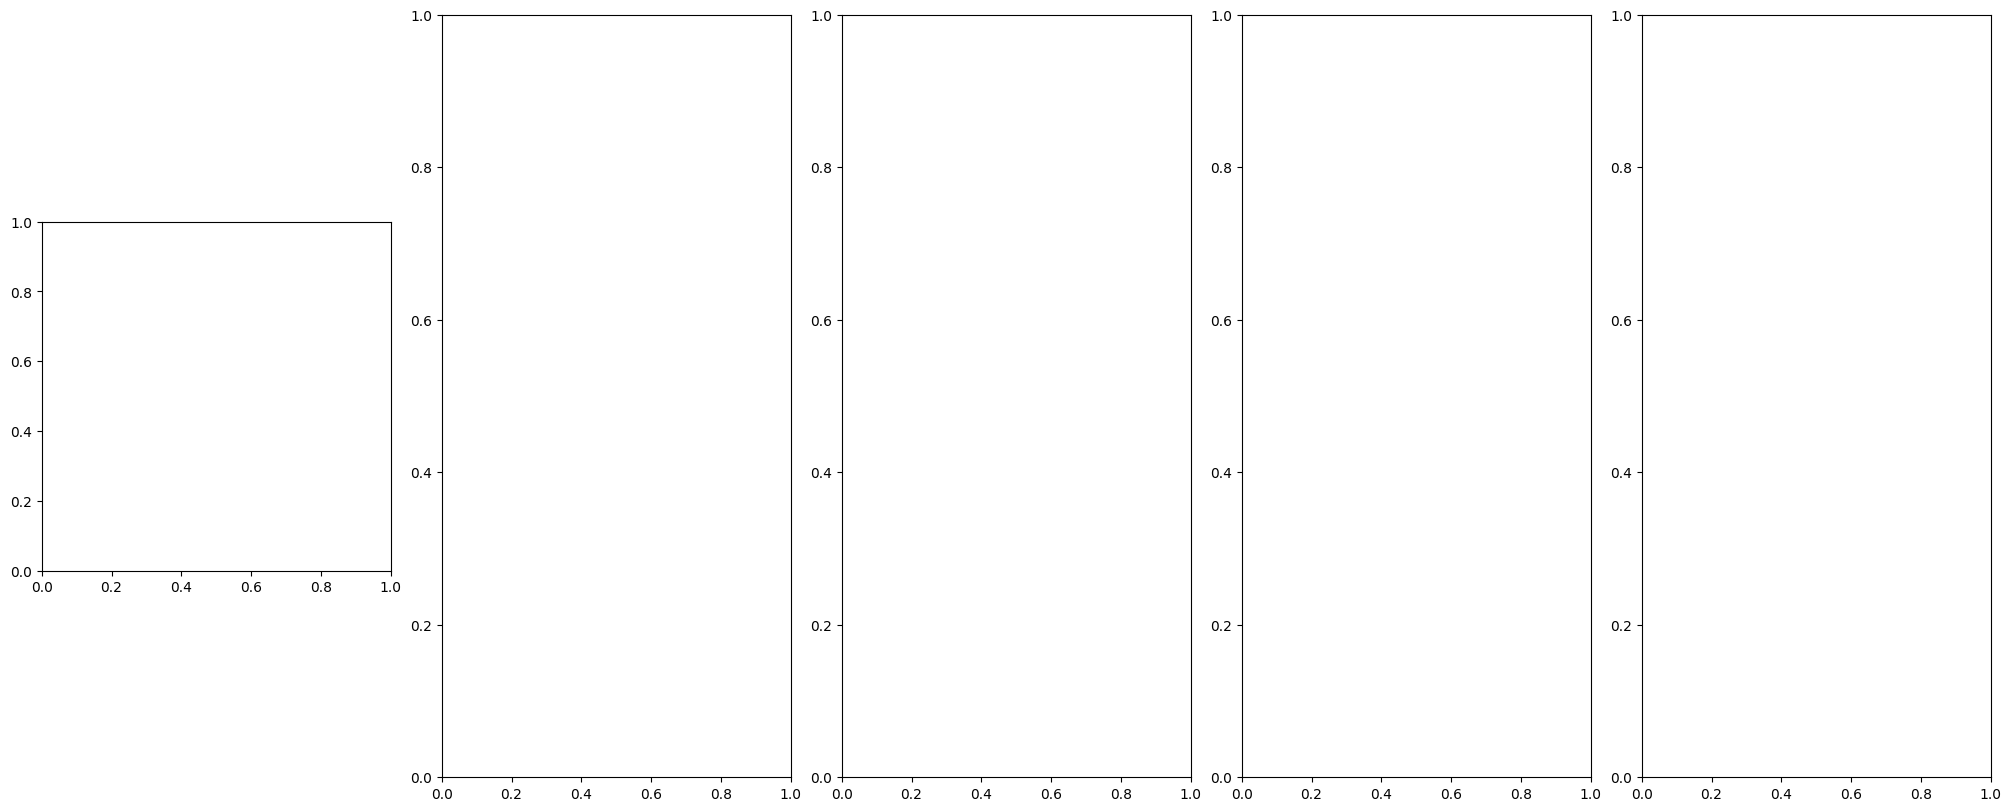

In [11]:
gal_type = ['E6', 'E3', 'E0', 'SAc', 'A', 'SoA']
gal_num = 5
ids = []
for id in gal_type: ids.append(train_results[train_results['train_label'] == id].sample(gal_num)['GalaxyID'].to_numpy())

for j, Type in enumerate(gal_type):
    fig, Ax = plt.subplots(1, gal_num, figsize=(20, 8), layout='constrained')
    for i, ax in enumerate(Ax):
        ax.set_aspect('equal', 'box')
        ax.imshow(Image.open('data/test_old/' +  str(ids[j][i]) + '.jpg').convert('L'), cmap='gray')
        ax.set_title(Type)
        ax.set_xticks([])
        ax.set_yticks([])
plt.show()